In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
test_df = pd.read_csv('../data/test_data.csv')


In [3]:
df = pd.read_csv('../data/large_train_sample.csv')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [8]:
df.shape

(32561, 14)

# EDA

## Categorical Variables

In [4]:
# Binarize sex column 
df['sex_m'] = [1 if i == ' Male' else 0 for i in df['sex']]
df.drop(columns = 'sex', inplace = True)

### Binarize Wage Target Class

In [5]:
df['wage'] = [1 if i == ' >50K' else 0 for i in df['wage']]
df['wage'].value_counts()

0    24720
1     7841
Name: wage, dtype: int64

In [6]:
df['hours-per-week'].value_counts()

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours-per-week, Length: 94, dtype: int64

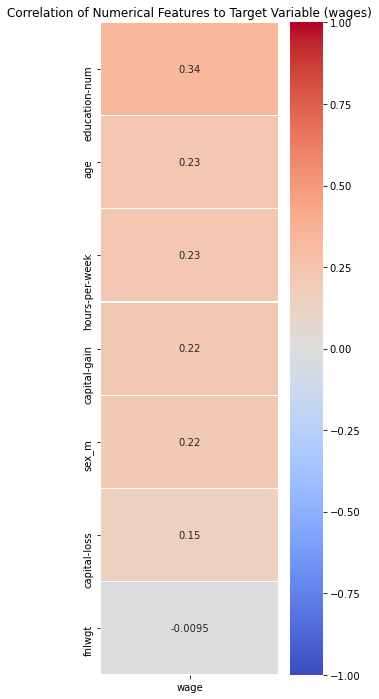

In [7]:
# Quick heatmap showing the correlation of all numerical features to our target variable to see if any should be dropped
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (4,12))

sns.heatmap(corr[['wage']].sort_values(by = 'wage', ascending=False).drop('wage'), cmap = 'coolwarm',
            annot = True, vmin = -1, vmax = 1, linewidth = 0.1, linecolor = 'w');
plt.title("Correlation of Numerical Features to Target Variable (wages)")
plt.savefig("../Images/heatmap.png", bbox_inches="tight")

In [11]:
# Drop fnlwgt since it has no impact and I don't think it's a true quantitative feature anyway
#df = df.drop(columns = ['education', 'fnlwgt'])

In [12]:
# Drop education since there is already education-num
df.drop(columns = 'education', inplace=True)

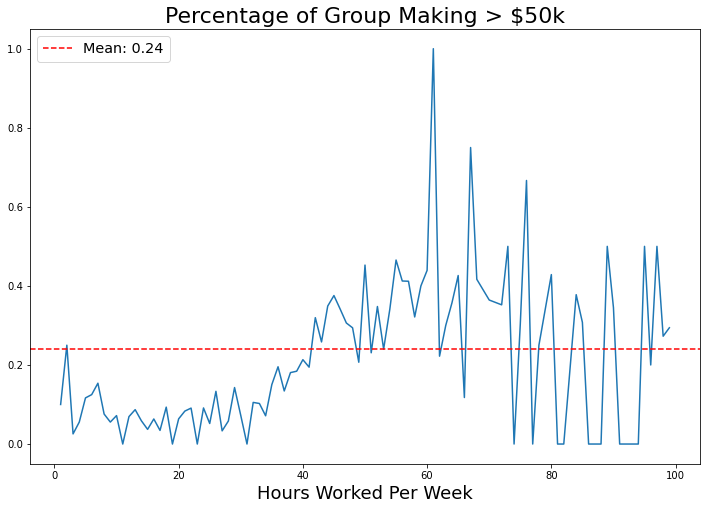

In [23]:
# Plot size
plt.figure(figsize = (12,8))
# Plot the relationship between hours-per-week and our target
plt.plot(df.groupby('hours-per-week')['wage'].mean());
# plot the average of our target class
plt.axhline(y = df['wage'].mean(), color = 'r', linestyle = '--', label = 'Mean: 0.24')
# Create a descriptive title
plt.title("Percentage of Group Making > $50k", fontsize = 22);
plt.xlabel('Hours Worked Per Week', fontsize = 18);
# add the legend
plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.savefig("../Images/income_weekly_hours.png", bbox_inches="tight")

In [13]:
df[df['hours-per-week'] > 60]['wage'].mean()

0.36396396396396397

In [14]:
df[df['hours-per-week'] < 40]['wage'].mean()

0.09506634033234575

In [15]:
columns = df.columns
cat_cols = []
for col in columns:
    if col not in df._get_numeric_data().columns:
        cat_cols.append(col)
cat_cols

['workclass', 'marital-status', 'occupation', 'relationship', 'native-country']

In [16]:
df = pd.get_dummies(df, columns = cat_cols, drop_first = True)
#test = pd.get_dummies(test, columns = ['Sex', 'Embarked'], drop_first = True)

df.shape

(32561, 82)

In [17]:
X = df.drop(columns='wage')
y = df['wage']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [ ]:
# Set up some modeling scaffolding

rf = RandomForestClassifier(random_state=33)
# I want to set up gridsearch params
params = {'n_estimators':      [2000],
          'max_features':      [None, 'sqrt'],
          'max_depth':         [8],
          'min_samples_split': [2],
          'min_samples_leaf':  [4],
          'ccp_alpha':         [0.0005]
}
gs = GridSearchCV(rf, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

with open('./data/rf6.pkl', 'wb') as file:
     pickle.dump(gs, file)
with open('./data/rf6.pkl', 'rb') as file:
    gs_rf = pickle.load(file)

    
search_results = gs_rf.cv_results_
top_estimator = gs_rf.best_estimator_
top_score = gs_rf.best_score_
top_parameters = gs_rf.best_params_

In [ ]:
top_parameters

In [ ]:
top_score

In [ ]:
gs.score(X_test, y_test)

### Resampling to balance classes

In [19]:
#Bootstrap data to create an additional 200_000 observations of class = ckd
wage_sample = df[df['wage'] == 1].sample(16879, replace = True, random_state = 42) 
df2 = pd.concat([df,wage_sample])
df2.shape

(49440, 82)

In [20]:
df2['wage'].value_counts()

1    24720
0    24720
Name: wage, dtype: int64

In [21]:
df2.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage,sex_m,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df2['sex_m'] = [1 if i == ' Male' else 0 for i in df2['sex']]

KeyError: 'sex'

In [ ]:
columns = df2.columns
cat_cols = []
for col in columns:
    if col not in df2._get_numeric_data().columns:
        cat_cols.append(col)
cat_cols

In [ ]:
# Add hours per week to the list of columns to be dummified
cat_cols += ['hours-per-week']
cat_cols

### Before Dummifying, we must find the categorical columns in the training and testing data that do not have the same number of categories

In [18]:
[len(df2[i].unique()) for i in cat_cols]

NameError: name 'df2' is not defined

In [ ]:
[len(test_df[i].unique()) for i in cat_cols]

*Find the missing country in the test data*

In [ ]:
country1 = df2['native-country'].unique()
country2 = test_df['native-country'].unique()
list_difference = []

for item in country1:
    if item not in country2:
        list_difference.append(item)
        
list_difference

In [ ]:
# We must add a column to the test_df to represent the missing netherlands category.

In [ ]:
df2['education-num'].value_counts()

In [ ]:
df2.shape

In [ ]:
df2 = pd.get_dummies(df2, columns = cat_cols, drop_first = True)
#test = pd.get_dummies(test, columns = ['Sex', 'Embarked'], drop_first = True)

df2.shape

In [ ]:
X = df2.drop(columns='wage')
y = df2['wage']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [ ]:
# Set up some modeling scaffolding

rf = RandomForestClassifier(random_state=33)
# I want to set up gridsearch params
params = {'n_estimators':      [100, 120, 140],
          'max_features':      ['sqrt', 'log2'],
          'max_depth':         [5, 6],
          'min_samples_split': [3, 4],
          'min_samples_leaf':  [3, 4],
          'ccp_alpha':         [0.0008, 0.001, 0.0012]
}
gs = GridSearchCV(rf, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

with open('./data/rf.pkl', 'wb') as file:
     pickle.dump(gs, file)
with open('./data/rf.pkl', 'rb') as file:
    gs_rf = pickle.load(file)

    
search_results = gs_rf.cv_results_
top_estimator = gs_rf.best_estimator_
top_score = gs_rf.best_score_
top_parameters = gs_rf.best_params_


In [ ]:
sr_df = pd.DataFrame(search_results)
sr_df

In [ ]:
top_estimator

In [ ]:
top_parameters

In [ ]:
top_score

In [ ]:
gs.score(X_test, y_test)

In [ ]:
test_df['Holand-Netherlands'] = 0

In [1]:
data_dict_final_model = {
    'age':['The age of the person sampled'],
    'workclass':['Evaluates the quality of the material on the exterior(Ordinal)'],
    'fnlwgt':['The weighted tally indicated likeness in socio-economic and demographic statistics.'],
    'education':['The highest level of education the person sampled achieved.(categorical)'],
       'education-num':['The highest level of education the person sampled achieved, ranked on a numbered scale (oridnal)'],
    'marital-status':['The marital status of the person sampled'],
    'occupation':['The job sector the person sampled works'],
    'relationship':['The relationship of the person sampled to the data given in the sample.'],
       'sex':['The gender of the person sampled'],
    'capital-gain':['Capital gains for the person sampled in dollars'],
    'capital-loss':['Capital losses for the person sampled in dollars'],
    'hours-per-week':['The average hours per week the person sampled works'],
    'native-country':['The country of origin for the person sampled'],
    'wage':['Binary outcome indicating whether the annual income for the person sampled was above or below 50k dollars.']
}


#This places the dataframe in a markdown friendly format so it can be copy/pasted into the README
dict_df = pd.DataFrame(data_dict_final_model).T.to_markdown()

dict_df

text_file = open("./data/data_dict","w")#if you don't include the "w" it will assume there is a file already called that and try to open a file that doesn't exist
#The "w" writes the file

text_file.write(dict_df)

text_file.close()

NameError: name 'pd' is not defined